In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd

ox.__version__

'2.0.1'

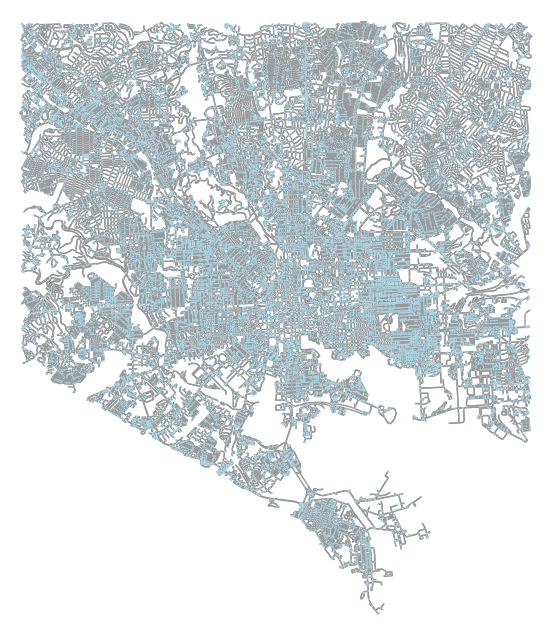

In [5]:
G = ox.graph.graph_from_place("Baltimore, Maryland, USA", network_type="bike")
fig, ax = ox.plot.plot_graph(G, node_size= 1, node_color='lightblue', bgcolor='w')

In [37]:
# 获取合并交叉口的GeoSeries
G_proj = ox.projection.project_graph(G)
ints = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=15, dead_ends=False
)
len(ints)


9627

In [33]:
len(G)

12602

In [35]:
# 合并交叉口并重建图拓扑
# 这将重新连接边缘几何到新的合并节点
G2 = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=True, tolerance=15, dead_ends=False
)
len(G2)

9694

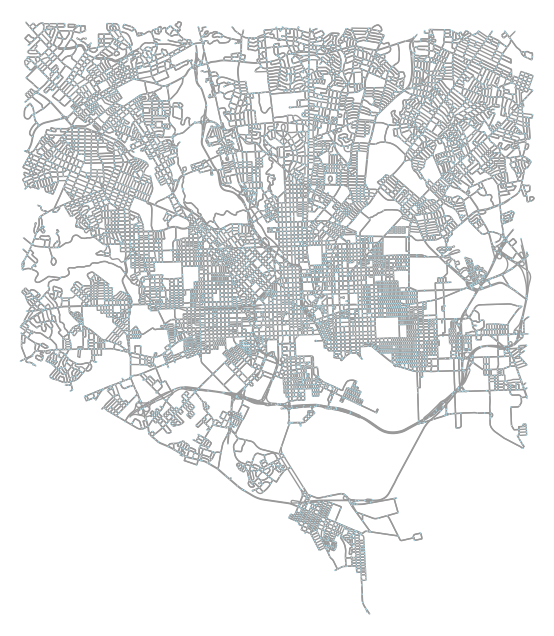

In [40]:
fig, ax = ox.plot.plot_graph(G2, node_size= 1, node_color='lightblue', bgcolor='w')


In [ ]:
# 您可以将图转换为节点和边的 GeoPandas GeoDataFrame
# gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
# gdf_nodes.head()
# gdf_edges.head()

#您可以从节点/边 GeoDataFrame 创建图，只要 gdf_nodes 按 osmid 索引，
# gdf_edges 按 u, v, key 多重索引（遵循正常的 MultiDiGraph 结构）。
# 这允许您将图节点/边的 ShapeFile 或 GeoPackage 图层加载为 GeoDataFrame，然后转换为 MultiDiGraph 以进行图分析。

# 将节点/边 GeoPandas GeoDataFrame 转换为 NetworkX MultiDiGraph
#G2 = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# 我们的网络覆盖的面积是多少平方米？
# G_proj = ox.projection.project_graph(G)
# nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
# graph_area_m = nodes_proj.union_all().convex_hull.area
# print(f"The area of the network is {graph_area_m} square meters.")

# # 显示网络的一些基本统计信息
# ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

## 可视化街道中心性

这里我们绘制街道网络，并根据其相对接近中心性为边（街道）着色。

In [23]:
# 将图转换为线图，使边变为节点，反之亦然(并没有这样做)
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

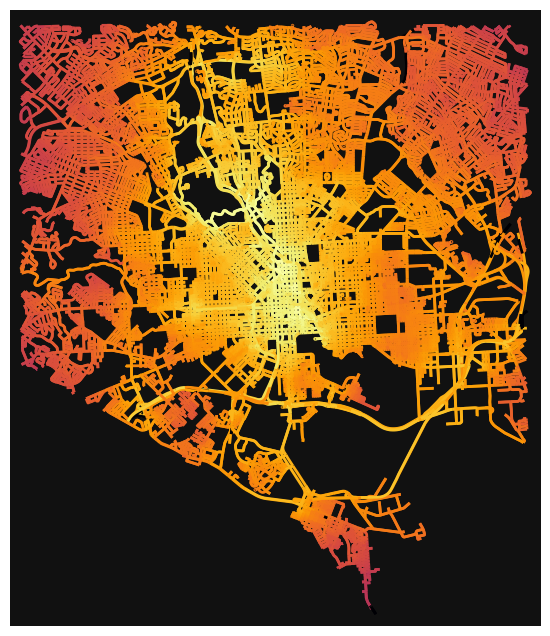

In [24]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## 路径规划

In [9]:
# 估算缺失的路速度并使用速度模块计算边旅行时间
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [12]:
# 使用距离模块获取两个经纬度点的最近网络节点
orig = ox.distance.nearest_nodes(G, X=-76.629244, Y=39.317355)
# dest = ox.distance.nearest_nodes(G, X=-76.601399, Y=39.288630)
dest = ox.distance.nearest_nodes(G, X=-76.579977, Y=39.262618)

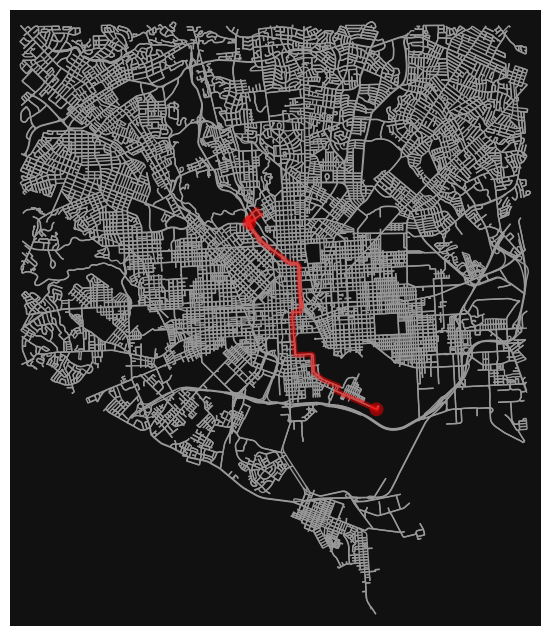

In [ ]:
# 找到节点之间的最短路径，最小化旅行时间，然后绘制它
route = ox.routing.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot.plot_graph_route(G, route, node_size=0)

In [14]:
# 我们的路线长度是多少米？
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

9753

In [15]:
# 这两个节点之间的直线距离是多少？
# 使用 OSMnx 的矢量化大圆距离（haversine）函数
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

6954

您可以使用 `elevation` 模块自动为图的节点添加高程属性，使用本地栅格文件或 Google Maps Elevation API。

In [20]:
# 自动为节点添加高程，计算边坡度，绘制网络
# 您需要 Google Elevation API 密钥才能运行此单元格！
# try:
#     from keys import google_elevation_api_key

#     G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
#     G = ox.elevation.add_edge_grades(G)

#     # 使用OSMnx内置的免费高程数据源（基于NASA SRTM）
#     # G = ox.elevation.add_node_elevations_raster(G)  # 或 source='aws'
#     # G = ox.elevation.add_edge_grades(G)

#     nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
#     fig, ax = ox.plot.plot_graph(
#         G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333"
#     )
# except ImportError:
#     print("您需要 google_elevation_api_key 才能运行此单元格。")

您需要 google_elevation_api_key 才能运行此单元格。


节点从最低高程（深蓝色）到最高高程（亮黄色）着色。

示例：创建基于高程的阻抗函数以绕过山丘。